## Assignment 4

### Author: Pugalarasu K

## 1. Download the Dataset

https://www.kaggle.com/code/kredy10/simple-lstm-for-text-classification/data

## 2. Import the required libraries

In [ ]:
import os
import re
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
import keras
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from google.colab import drive

In [ ]:
#Mount and access drive
drive.mount('/content/drive',force_remount=True)
os.chdir('/content/drive/My Drive')
print("Change successful.")

Mounted at /content/drive
Change successful.


## 3.Read the dataset and do pre-processing

In [ ]:
spam_df = pd.read_csv(filepath_or_buffer='Dataset-3_Spam.csv', delimiter=',',encoding='latin-1')
spam_df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
#List the column names
spam_df.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [ ]:
#Drop the unnamed columns
spam_df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
spam_df.columns

Index(['v1', 'v2'], dtype='object')

In [ ]:
#Print the number of rows in the dataset
spam_df.shape

(5572, 2)

In [ ]:
#Get the summary statistics of the dataset
spam_df.describe()

,v1,v2
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [ ]:
#Check for null values
spam_df.isna().sum()

v1    0
v2    0
dtype: int64

In [ ]:
#Check for duplicated rows
spam_df.duplicated().sum()

403

In [ ]:
#Remove the duplicated rows
spam_df = spam_df.drop_duplicates()
spam_df.duplicated().sum()

0

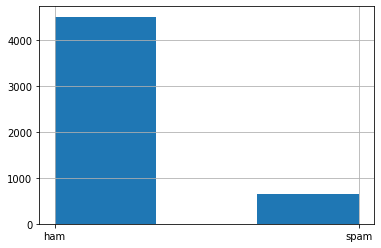

In [ ]:
#Display the count of spam and ham labels
#Stratified-split is required
spam_df['v1'].hist(bins=3)

In [ ]:
def wordcloud_vis(column):
  mostcommon = nltk.FreqDist(spam_df[column]).most_common(100)
  wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
  fig = plt.figure(figsize=(30,10), facecolor='white')
  plt.imshow(wordcloud) #, interpolation="bilinear")
  plt.axis('off')
  plt.show()

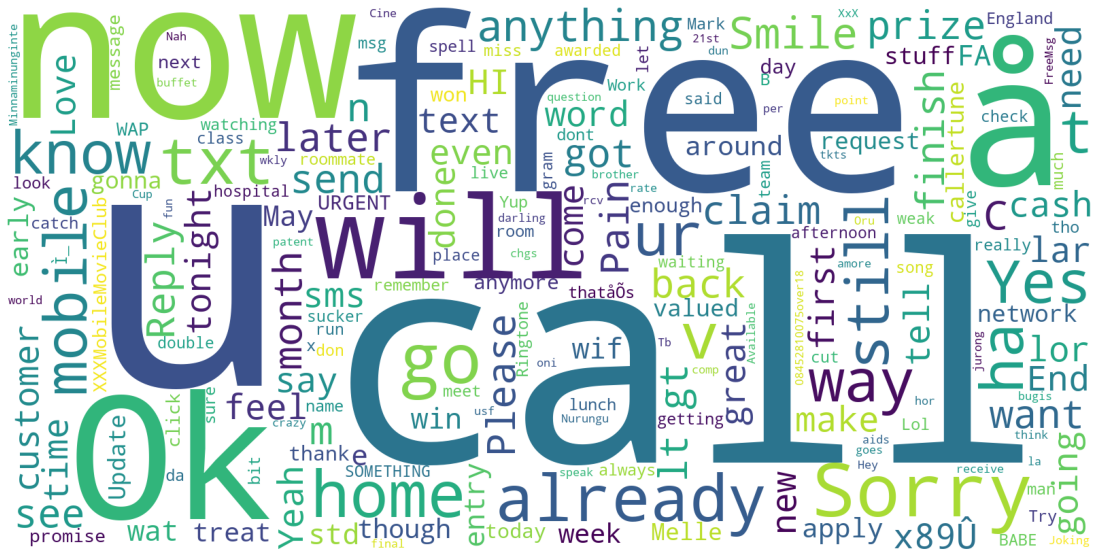

In [ ]:
#Plot the word-cloud before removing stopwords, performing lemmatization
wordcloud_vis('v2')

In [ ]:
#Retain only the letters and spaces
spam_df['alpha_text'] = spam_df['v2'].apply(lambda x: re.sub(r'[^a-zA-Z ]+', '', x.lower()))
spam_df.head()

,v1,v2,alpha_text
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final...
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...


In [ ]:
#Remove stop-words
nltk.download('stopwords')
spam_df['imp_text'] = spam_df['alpha_text'].apply(lambda x : ' '.join([word for word in x.split() if not word in set(stopwords.words('english'))]))
spam_df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,v1,v2,alpha_text,imp_text
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final...,free entry wkly comp win fa cup final tkts st ...
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...,nah dont think goes usf lives around though


In [ ]:
#Tokenize the data
def tokenize(data):
  generated_token = list(data.split())
  return generated_token
spam_df['token_text'] = spam_df['imp_text'].apply(lambda x: tokenize(x))
spam_df.head()

,v1,v2,alpha_text,imp_text,token_text
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...,go jurong point crazy available bugis n great ...,"[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final...,free entry wkly comp win fa cup final tkts st ...,"[free, entry, wkly, comp, win, fa, cup, final,..."
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,u dun say early hor u c already say,"[u, dun, say, early, hor, u, c, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...,nah dont think goes usf lives around though,"[nah, dont, think, goes, usf, lives, around, t..."


In [ ]:
#Perform lemmatization
nltk.download('wordnet')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()
def lemmatization(list_of_words):
  lemmatized_list = [lemmatizer.lemmatize(word) for word in list_of_words]
  return lemmatized_list
spam_df['lemmatized_text'] = spam_df['token_text'].apply(lambda x: lemmatization(x))
spam_df.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


,v1,v2,alpha_text,imp_text,token_text,lemmatized_text
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...,go jurong point crazy available bugis n great ...,"[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final...,free entry wkly comp win fa cup final tkts st ...,"[free, entry, wkly, comp, win, fa, cup, final,...","[free, entry, wkly, comp, win, fa, cup, final,..."
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,u dun say early hor u c already say,"[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, early, hor, u, c, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...,nah dont think goes usf lives around though,"[nah, dont, think, goes, usf, lives, around, t...","[nah, dont, think, go, usf, life, around, though]"


In [ ]:
#Combine the tokens (into sentences) to get the final cleansed data
spam_df['clean'] = spam_df['lemmatized_text'].apply(lambda x: ' '.join(x))
spam_df.head()

,v1,v2,alpha_text,imp_text,token_text,lemmatized_text,clean
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...,go jurong point crazy available bugis n great ...,"[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazy, available, bugis, n...",go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni,ok lar joking wif u oni,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]",ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final...,free entry wkly comp win fa cup final tkts st ...,"[free, entry, wkly, comp, win, fa, cup, final,...","[free, entry, wkly, comp, win, fa, cup, final,...",free entry wkly comp win fa cup final tkts st ...
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say,u dun say early hor u c already say,"[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, early, hor, u, c, already, say]",u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...,nah dont think goes usf lives around though,"[nah, dont, think, goes, usf, lives, around, t...","[nah, dont, think, go, usf, life, around, though]",nah dont think go usf life around though


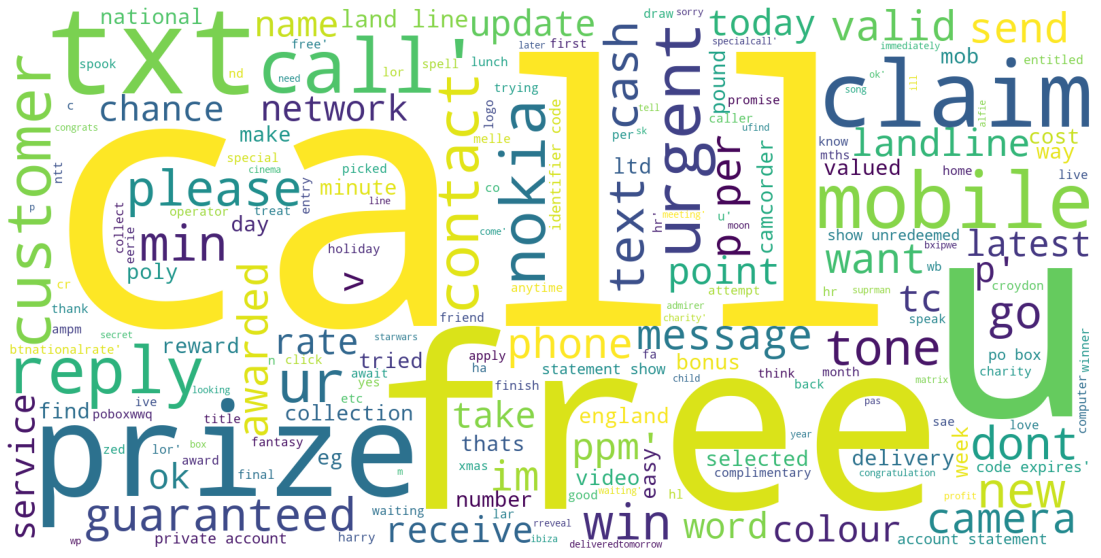

In [ ]:
#Display the wordcloud after preprocessing
wordcloud_vis('clean')

In [ ]:
#Number of unique words in spam and ham
df1 = spam_df.loc[spam_df['v1'] == 'spam']
df2 = spam_df.loc[spam_df['v1'] == 'ham']

spam = set()
df1['clean'].str.lower().str.split().apply(spam.update)
print("Number of unique words in spam", len(spam))

ham = set()
df2['clean'].str.lower().str.split().apply(ham.update)
print("Number of unique words in ham", len(ham))

Number of unique words in spam 2037
Number of unique words in ham 6738


In [ ]:
#Find the number of overlapping words between spam and ham labels
print("Number of overlapping words between spam and ham: ", len(spam & ham))

Number of overlapping words between spam and ham:  895


In [ ]:
#Maximum number of words in a sentence
#Useful for applying padding
spam_df['clean'].apply(lambda x:len(str(x).split())).max()

80

In [ ]:
#Prepare the data for training
X = spam_df['clean']
y = spam_df['v1']

In [ ]:
#Convert the class labels into integer values
le = LabelEncoder()
y = le.fit_transform(y)
y

array([0, 0, 1, ..., 0, 0, 0])

In [ ]:
X.shape

(5169,)

In [ ]:
y.shape

(5169,)

In [ ]:
#Split the data into train, test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

In [ ]:
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(X_train)
tokenized_train = tokenizer.texts_to_sequences(X_train)
X_train = tf.keras.utils.pad_sequences(tokenized_train, maxlen=100)

In [ ]:
tokenized_test = tokenizer.texts_to_sequences(X_test)
X_test = tf.keras.utils.pad_sequences(tokenized_test, maxlen=100)

## 4. Create the model

In [ ]:
#Create a wrapper to add layers to the model
model = Sequential()

## 5. Add Layers (LSTM, Dense-(Hidden Layers), Output)

In [ ]:
model.add(Embedding(1000, output_dim=50, input_length=100))
model.add(LSTM(units=64 , return_sequences = True, dropout = 0.2))
model.add(LSTM(units=32 , dropout = 0.1))
model.add(Dense(units = 64 , activation = 'relu'))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 100, 50)           50000     
                                                                 
 lstm_38 (LSTM)              (None, 100, 64)           29440     
                                                                 
 lstm_39 (LSTM)              (None, 32)                12416     
                                                                 
 dense_25 (Dense)            (None, 64)                2112      
                                                                 
 dense_26 (Dense)            (None, 32)                2080      
                                                                 
 dense_27 (Dense)            (None, 1)                 33        
                                                                 
Total params: 96,081
Trainable params: 96,081
Non-tra

## 6. Compile the Model

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## 7. Fit the Model

In [ ]:
model.fit(X_train, y_train, batch_size=128,epochs=10,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',patience=2)])

Epoch 1/10
28/28 [==============================] - 13s 308ms/step - loss: 0.4777 - accuracy: 0.8603 - val_loss: 0.3748 - val_accuracy: 0.8760
Epoch 2/10
28/28 [==============================] - 8s 272ms/step - loss: 0.3768 - accuracy: 0.8731 - val_loss: 0.3598 - val_accuracy: 0.8760
Epoch 3/10
28/28 [==============================] - 8s 271ms/step - loss: 0.2600 - accuracy: 0.8990 - val_loss: 0.1339 - val_accuracy: 0.9647
Epoch 4/10
28/28 [==============================] - 8s 272ms/step - loss: 0.0874 - accuracy: 0.9772 - val_loss: 0.0870 - val_accuracy: 0.9738
Epoch 5/10
28/28 [==============================] - 8s 271ms/step - loss: 0.0602 - accuracy: 0.9829 - val_loss: 0.0748 - val_accuracy: 0.9761
Epoch 6/10
28/28 [==============================] - 7s 268ms/step - loss: 0.0520 - accuracy: 0.9843 - val_loss: 0.0687 - val_accuracy: 0.9772
Epoch 7/10
28/28 [==============================] - 8s 270ms/step - loss: 0.0350 - accuracy: 0.9898 - val_loss: 0.0646 - val_accuracy: 0.9795
Epoch

## 8. Save the Model

In [ ]:
model.save('spam-classifier.h5')

## 9. Test the Model

In [ ]:
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

25/25 [==============================] - 1s 26ms/step - loss: 0.0625 - accuracy: 0.9871
Accuracy of the model on Testing Data is -  98.71134161949158 %
